In [10]:
# !pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 1.4 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.1 MB/s eta 0:00:00a 0:00:01


In [33]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer

from scipy.cluster.hierarchy import ward, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from gensim.models import FastText

In [2]:
# embeddings = pd.read_pickle("../data/clean_2020articles_w_title_embeddings.pkl")
embeddings = pd.read_csv("../data/metadata_w_2020articles_cleaned.csv")

In [3]:
# embeddings

In [24]:
# only training on 3700 articles because cosine similarity is 
# very computationally intensive
train, test = train_test_split(embeddings, test_size=0.7, random_state=42)

# If using Fast Text Embeddings do the following:

In [40]:
corpus = train.loc[:, 'title'].values
corpus.shape

(11113,)

In [15]:
# cv = CountVectorizer(ngram_range=(1, 2), min_df=0.001, max_df=0.99)
# cv_matrix = cv.fit_transform(corpus)
# cv_matrix.shape

In [26]:
# tokenizing title docs
tokenized_docs = [doc.split() for doc in corpus]
ft_model = FastText(tokenized_docs, vector_size=512, window=20, min_count=2, 
                    workers=1, sg=1, seed=42, epochs=10)

In [27]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)

    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.

        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                for tokenized_sentence in corpus]
    return np.array(features)

In [28]:
doc_vecs_ft = averaged_word2vec_vectorizer(tokenized_docs, ft_model, 512)
doc_vecs_ft


array([[-0.08646769, -0.09509287, -0.02140042, ..., -0.0946512 ,
        -0.06510274,  0.06842217],
       [ 0.02036671,  0.00396023,  0.09626008, ..., -0.15536568,
        -0.1102221 ,  0.20106385],
       [-0.03745764, -0.01495305,  0.05020596, ..., -0.15402553,
        -0.08614743,  0.05799291],
       ...,
       [-0.08204891, -0.03573585,  0.03362475, ..., -0.13838087,
        -0.08368627,  0.07662232],
       [-0.09324032, -0.00190545,  0.00141828, ..., -0.12030176,
        -0.02704351,  0.02297155],
       [-0.13551173,  0.0242161 ,  0.05073271, ..., -0.08861181,
        -0.10709585,  0.01367074]])

In [10]:
# doc_vecs_ft[0]

### BERT embeddings:

In [7]:
# If using BERT embeddings, start from here and uncomment the subsequent lines
# train["bert_embeddings"] = train["bert_sentence_embedding_title_only"].apply(lambda x: x.cpu())
# train["np_embeddings"] = train["bert_embeddings"].apply(lambda x: x.numpy())
# np_embedding = np.vstack(train["np_embeddings"])

In [12]:
# np_embedding[0]

### Hierarchical clustering (regardless of embedding)

In [29]:
def ward_hierarchical_clustering(feature_matrix):
    # this cosine similarity part seems to be super compute heavy 
    # and so it doesnt scale w more than ~300 articles
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_hierarchical_clusters(linkage_matrix, data, p=100, figure_size=(8,12), embedding=''):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    titles = data['title'].values.tolist()
    # plot dendrogram
    R = dendrogram(linkage_matrix, orientation="left",
                   truncate_mode='lastp', # TODO probably want to use level instead
                   p=p,
                   no_plot=True)
    temp = {R["leaves"][ii]: titles[ii] for ii in range(len(R["leaves"]))}

    def llf(xx):
        return "{}".format(temp[xx])

    ax = dendrogram(
            linkage_matrix,
            truncate_mode='lastp', # TODO probably want to use level instead
            orientation="left",
            p=p,
            leaf_label_func=llf,
            leaf_font_size=10.,
            )
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig(f'../data/hierachical_clusters_{p}_{embedding}.png', dpi=200)

In [ ]:
# to create hierarchical clusters using the BERT embeddings
bert_linkage_matrix = ward_hierarchical_clustering(np_embedding)

In [31]:
# to create hierarchical clusters using the fast_text embeddings
fast_text_linkage_matrix = ward_hierarchical_clustering(doc_vecs_ft)

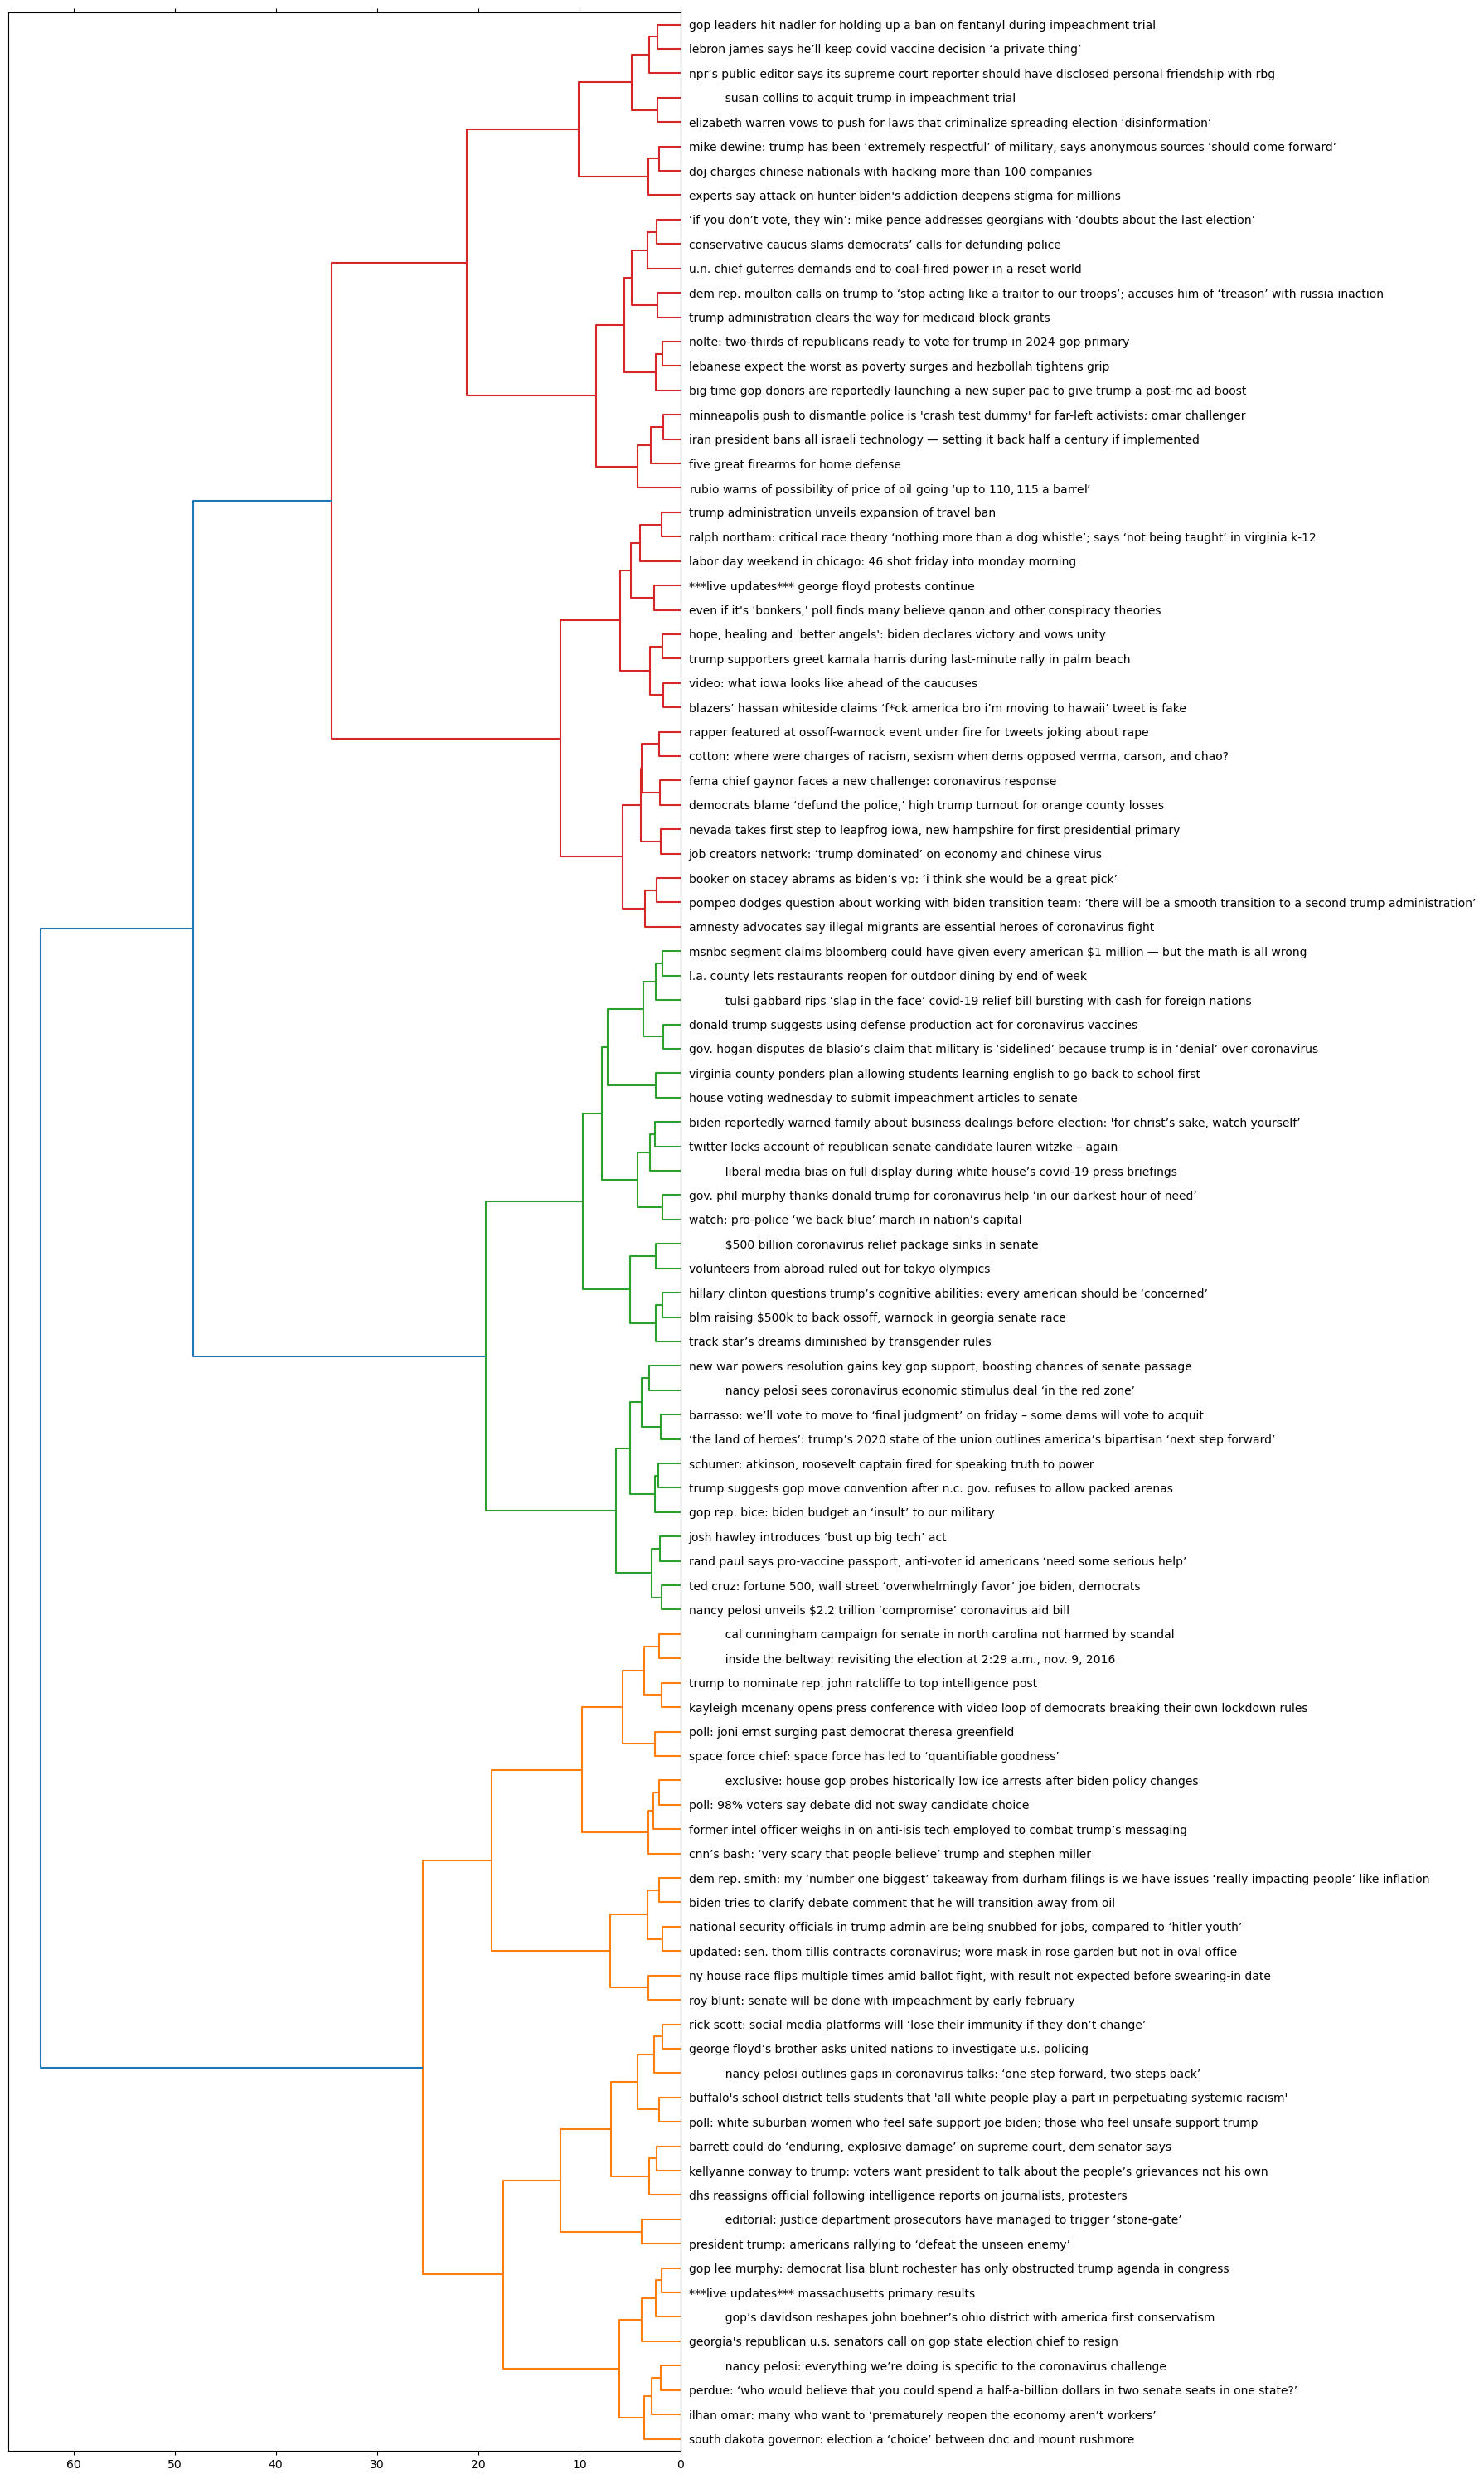

In [22]:
plot_hierarchical_clusters(fast_text_linkage_matrix,
                           p=100,
                           data=train,
                           figure_size=(18, 30),
                           embedding='fast_text')

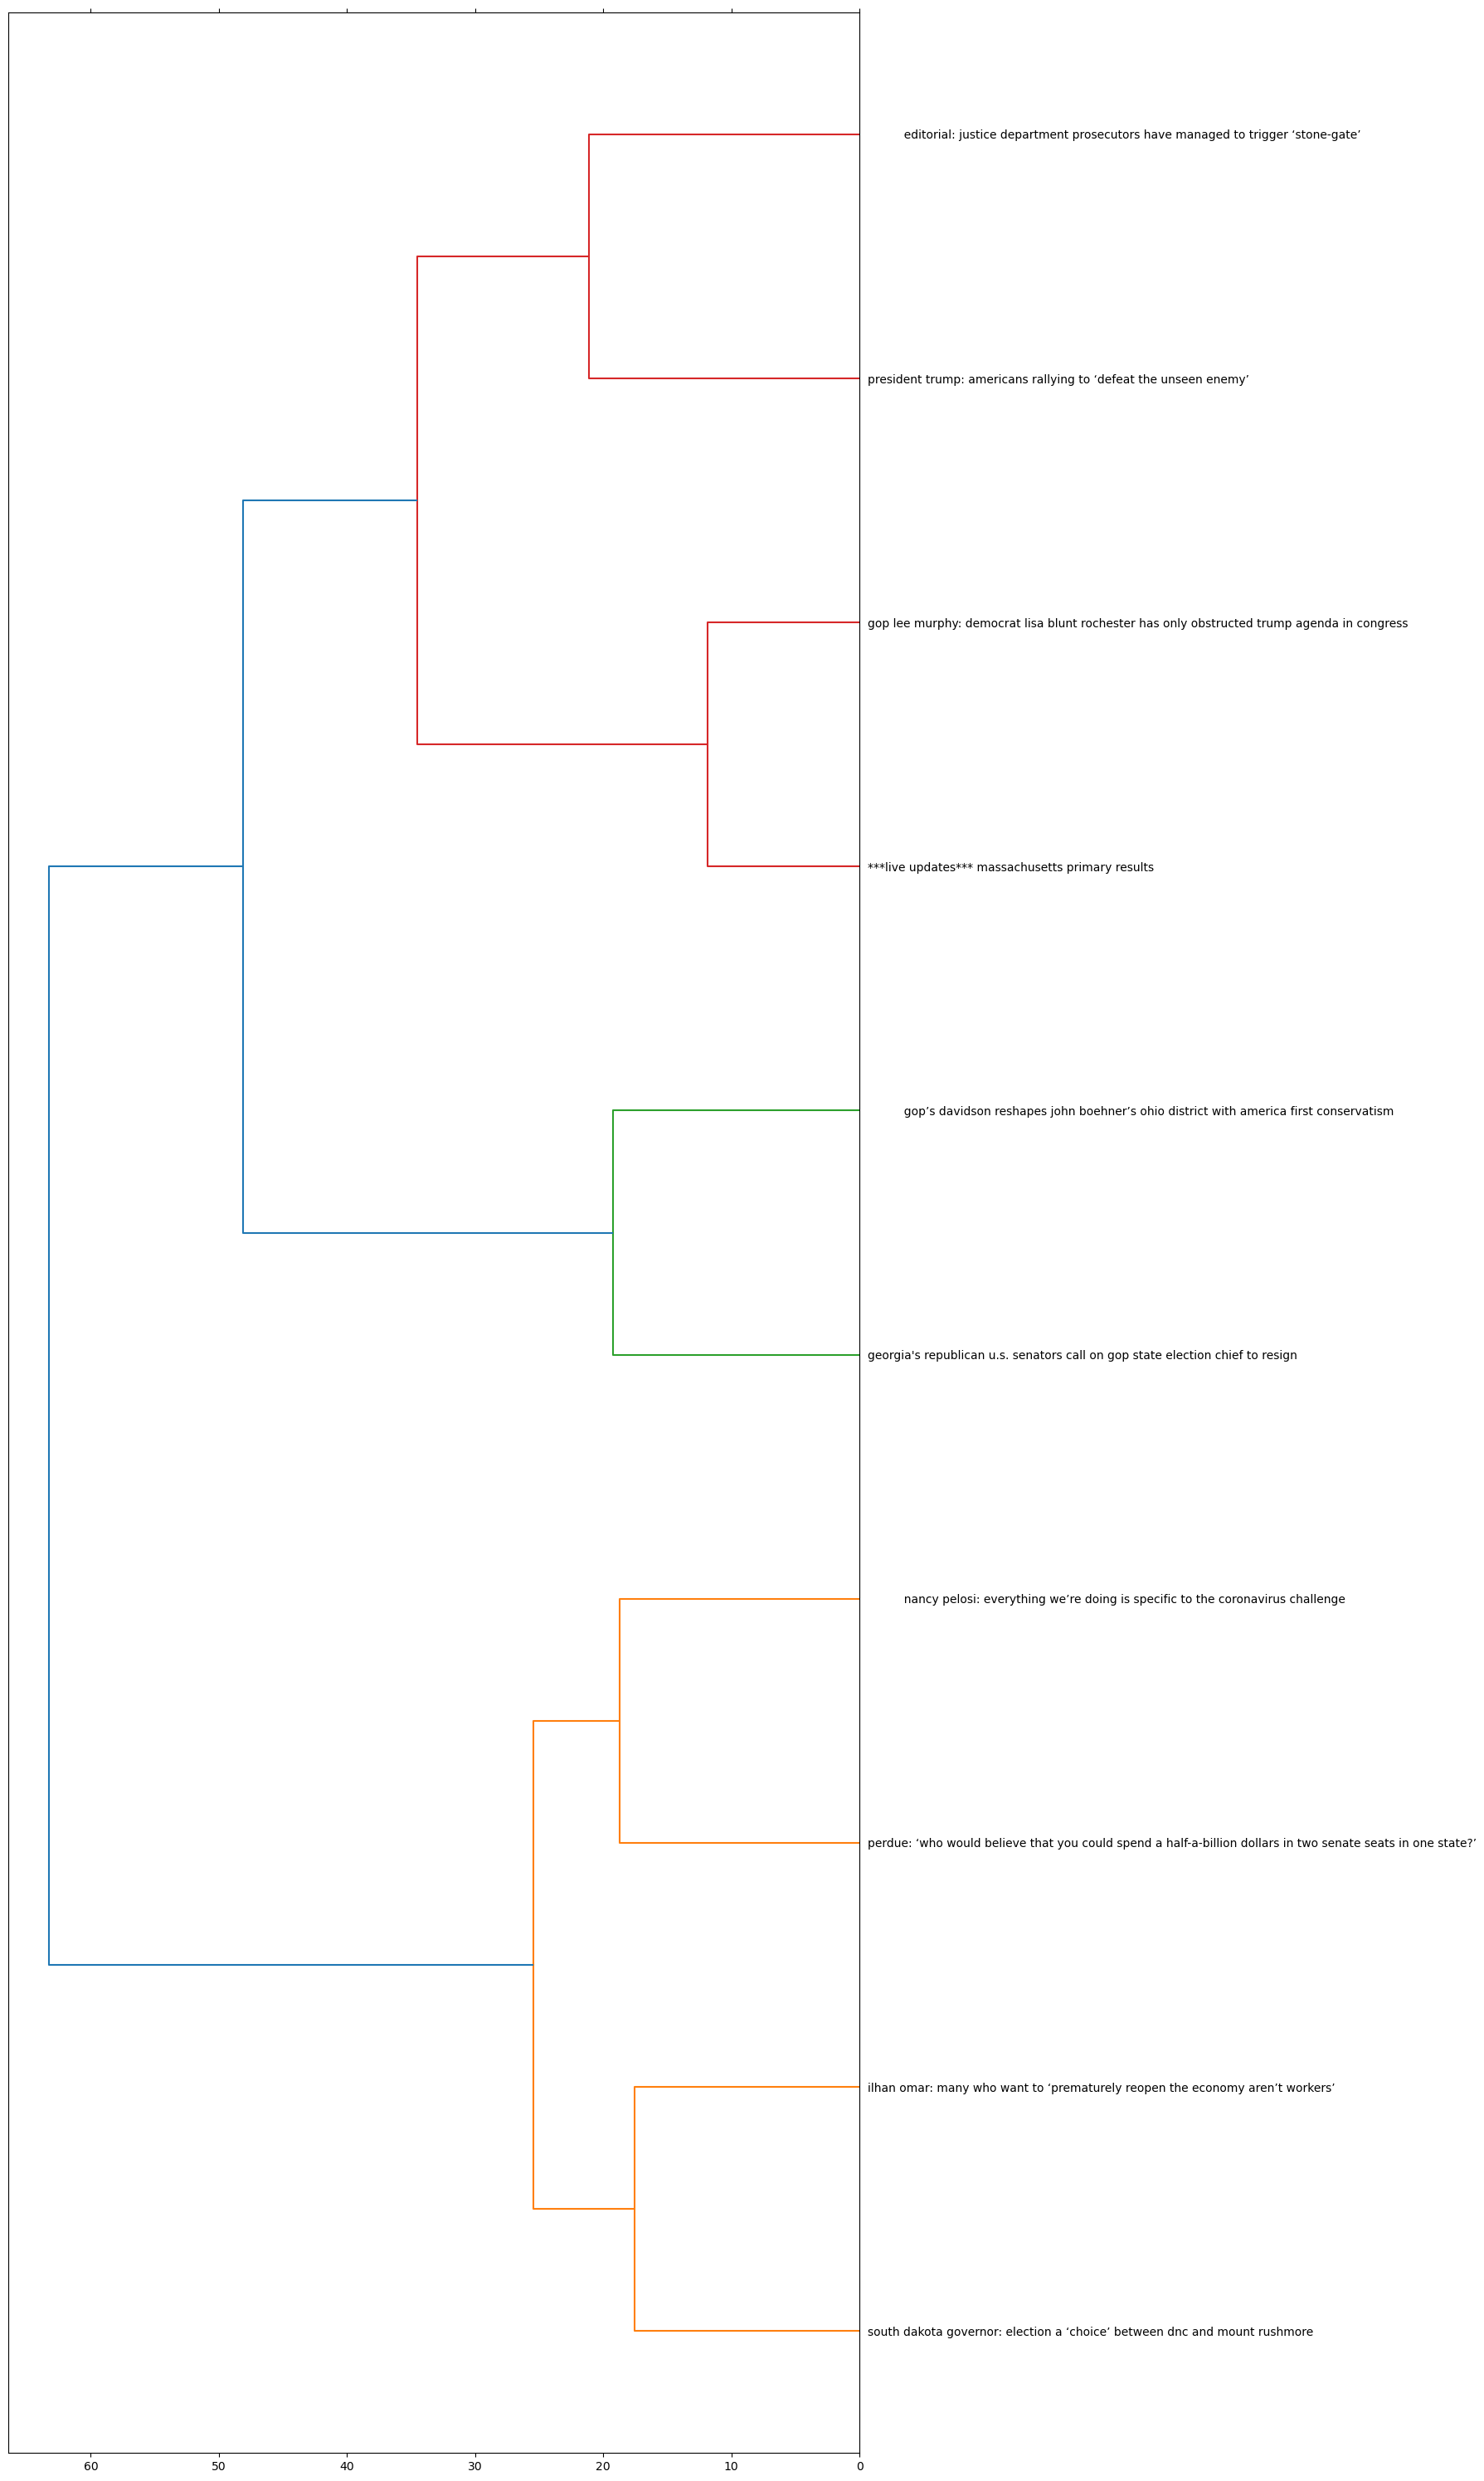

In [23]:
plot_hierarchical_clusters(fast_text_linkage_matrix,
                           p=10,
                           data=train,
                           figure_size=(18, 30),
                           embedding='fast_text')

In [39]:
# This actually assigns a cluster number to each item depending on a certain cutoff point
# using a distance of 15 would give us 27 clusters for the bert example!!
# fcluster(bert_linkage_matrix, 15, criterion='distance').max()

# fast text seems to have further distances (may also have been working with more values)
fcluster(fast_text_linkage_matrix, 30, criterion='distance').max()

72

In [ ]:
fcluster(bert_linkage_matrix, 0.3, criterion='distance')

In [ ]:
# TODO map cluster numbers back to articles in training set and doo topic analysis